# Overfitting and Regularization

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [3]:
set_config(display='diagram')

## Settings

In [4]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [5]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

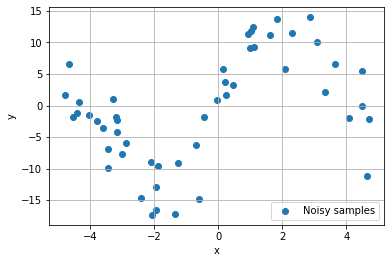

In [6]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

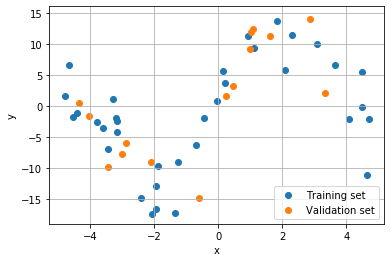

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [8]:
PolynomialFeatures(degree=4).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.,   1.],
       [  1.,   3.,   9.,  27.,  81.],
       [  1.,   4.,  16.,  64., 256.]])

In [9]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression(fit_intercept=False)
    
    # lasso regression
    elif penalty == 'L1':
        regressor = Lasso(fit_intercept=False, alpha=alpha, random_state=SEED, max_iter=50000)        
    
    # ridge regression
    elif penalty == 'L2':
        regressor = Ridge(fit_intercept=False, alpha=alpha, random_state=SEED, max_iter=50000)        
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree)),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures()), ('sca', StandardScaler()),
                ('reg', LinearRegression(fit_intercept=False))])

Pipeline(steps=[('pol', PolynomialFeatures()), ('sca', StandardScaler()),
                ('reg',
                 Lasso(alpha=0.1, fit_intercept=False, max_iter=50000,
                       random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures()), ('sca', StandardScaler()),
                ('reg',
                 Ridge(alpha=0.1, fit_intercept=False, max_iter=50000,
                       random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

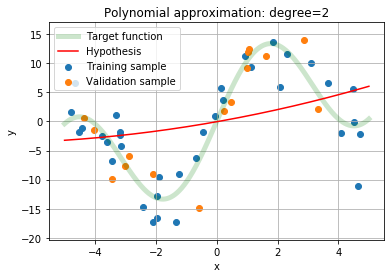

In [10]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

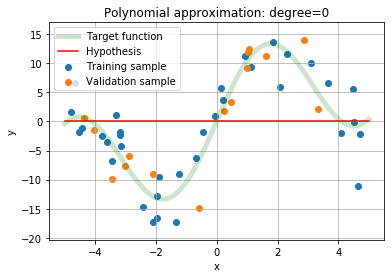

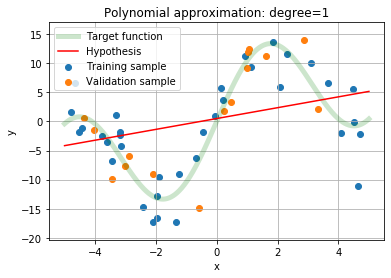

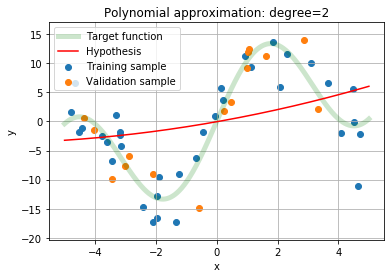

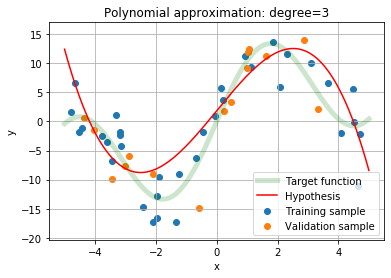

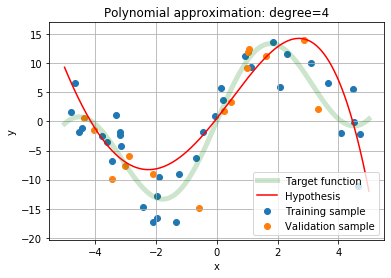

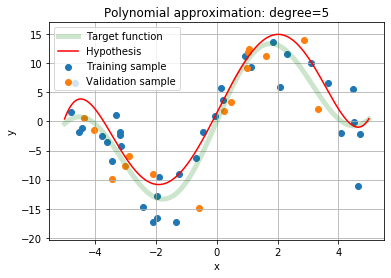

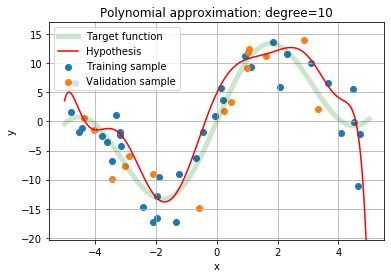

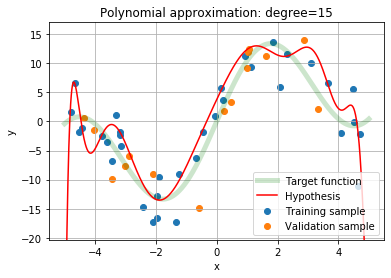

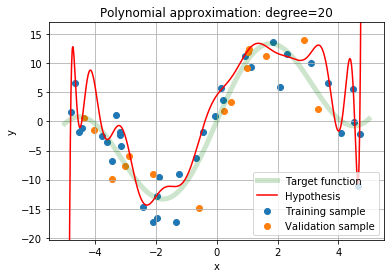

In [11]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

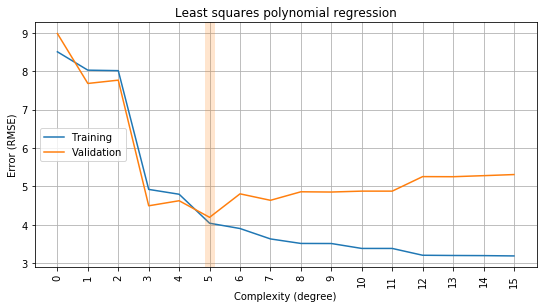

In [12]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [13]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

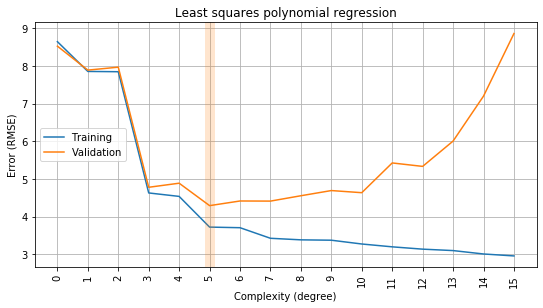

In [14]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [15]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([0.        , 2.81292778]),
 array([0.        , 2.80049884, 0.45166501]),
 array([  0.        ,  30.87315584,   1.48752361, -54.60227825,
         -1.63699842,  26.62792933]),
 array([   0.        ,   33.63850705,  -41.86346242,  -70.48743112,
         278.98853452,   27.48125634, -656.36383501,   59.32988346,
         651.64795186,  -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

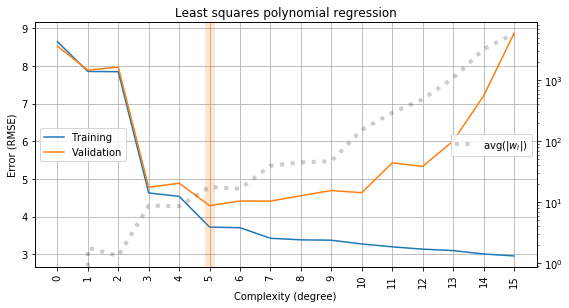

In [16]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

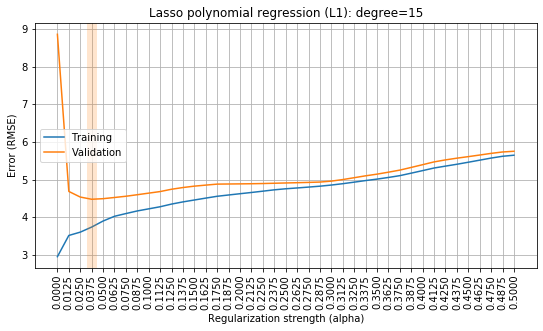

In [17]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

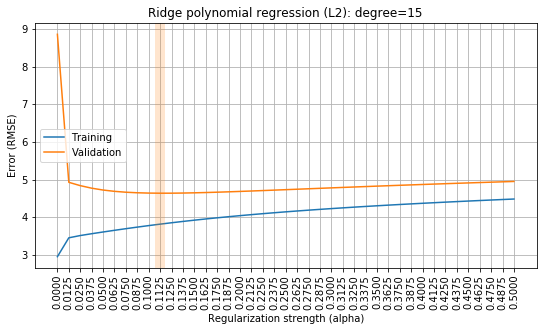

In [18]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

### Excercise 1 - Magnitude (4 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

In [19]:
def plot_weights_graph(x, metric, xlabel, ylabel, 
                       custom_label='', custom_scale='log', title='Weights graph'):
    plt.figure(figsize=(12, 4.5))
    plt.plot(x, metric, label='Weights')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')               
    plt.show()
    
def sum_weights(X_pred, y_pred, degree, penalty, alpha):
    x = make_model(degree=degree, penalty=penalty, alpha=alpha).fit(X_pred, y_pred)['reg'].coef_
    return np.absolute(x).sum()

Let's visualize the sum of weights tendency - we will find the value with different alpha from ALPHAS.

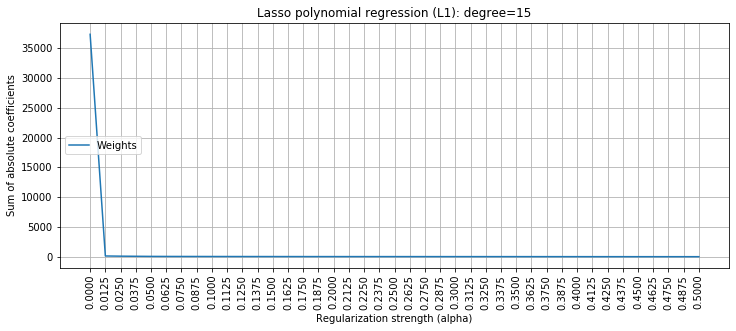

In [20]:
ALPHAS = np.linspace(0, 0.5, 1 + 40)
weights_l1 = []
for alpha in ALPHAS:    
    results = sum_weights(X_train, y_train, degree=15, penalty='L1', alpha = alpha)
    weights_l1.append(results)

    
plot_weights_graph(ALPHAS, weights_l1,
                   xlabel='Regularization strength (alpha)', ylabel='Sum of absolute coefficients',
                   title='Lasso polynomial regression (L1): degree=15')



The graph above gives a common idea what is happening. But after alpha = 0.0125 it is rather hard to be read because weights seem to be zero all the time. All is simple, we have such graph scaling because of extremely high weights sum given alpha = 0.

So let's have more detailed view and start from alpha = 0.005

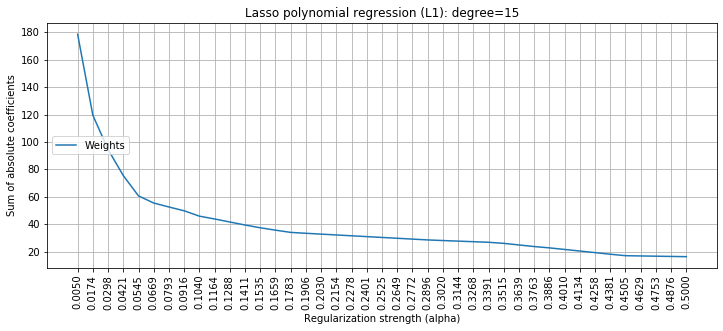

In [21]:
ALPHAS = np.linspace(0.005, 0.5, 1 + 40)
weights_l1 = []
for alpha in ALPHAS:    
    results = sum_weights(X_train, y_train, degree=15, penalty='L1', alpha = alpha)
    weights_l1.append(results)

    
plot_weights_graph(ALPHAS, weights_l1,
                   xlabel='Regularization strength (alpha)', ylabel='Sum of absolute coefficients',
                   title='Lasso polynomial regression (L1): degree=15')

#### L2

Again, let's have a bird-eye view on the sum_weights.

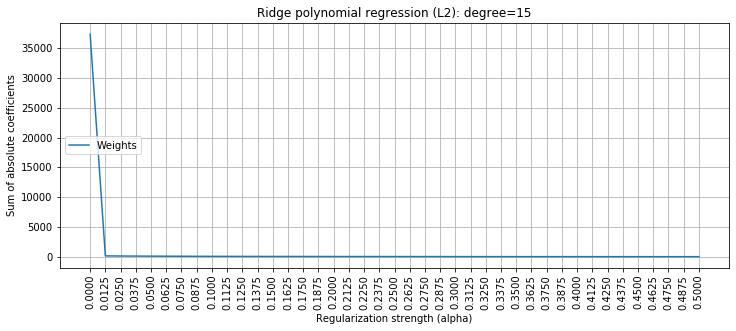

In [22]:
ALPHAS = np.linspace(0, 0.5, 1 + 40)
weights_l2 = []
for alpha in ALPHAS:    
    results = sum_weights(X_train, y_train, degree=15, penalty='L2', alpha = alpha)
    weights_l2.append(results)

    
plot_weights_graph(ALPHAS, weights_l2,
                   xlabel='Regularization strength (alpha)', ylabel='Sum of absolute coefficients',
                   title='Ridge polynomial regression (L2): degree=15')

Like in the previous example, we want to have a more detailed view and thus change the alpha starting point.

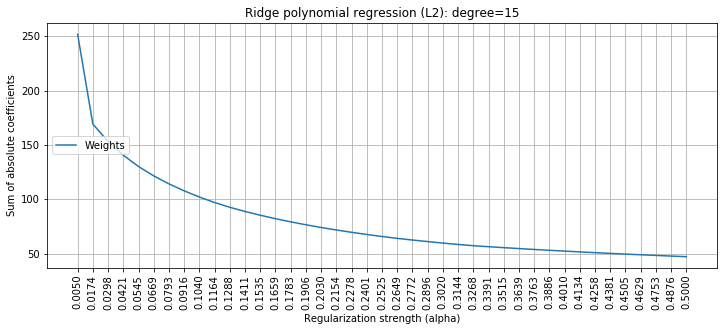

In [23]:
ALPHAS = np.linspace(0.005, 0.5, 1 + 40)
weights_l2 = []
for alpha in ALPHAS:    
    results = sum_weights(X_train, y_train, degree=15, penalty='L2', alpha = alpha)
    weights_l2.append(results)

    
plot_weights_graph(ALPHAS, weights_l2,
                   xlabel='Regularization strength (alpha)', ylabel='Sum of absolute coefficients',
                   title='Ridge polynomial regression (L2): degree=15')

#### Summary

In this exercise I tried to show on the graph that both Ridge and Lasso regularization methods **lead to constraining the weights (model coefficients)**.

Why did I choose sum of weights? The reason is simple - if we want to observe that each model coefficient goes down, we can just find a sum of them and observe its tendency to be sure that all coefficients are getting shrunk to zero.

I want to pay your attention that in this example I found the sum of **absolute** coefficient values. It is very important because we want to be sure that sum is decreasing due to the diminution of weights and not to the fact that positive and negative coefficient values can compensate each other.

### Excercise 2 - Sparsity (4 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

C:\Users\dasha\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 137.48920959290098, tolerance: 0.2532955762227167
  positive)


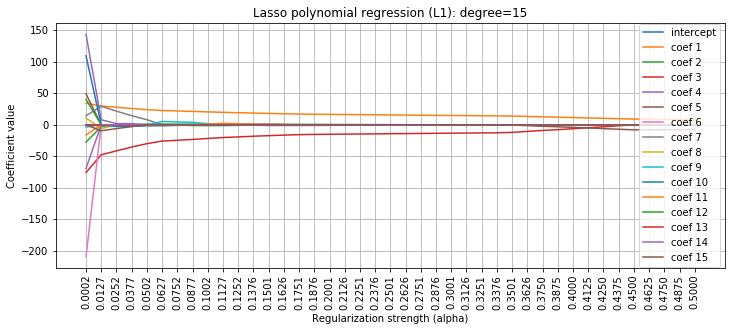

In [24]:
def plot_coef_graph(x, coef_0, coef_1, coef_2, coef_3, coef_4, coef_5, coef_6, coef_7, coef_8, coef_9, coef_10, coef_11, coef_12, coef_13, coef_14, coef_15, 
                       xlabel, ylabel, 
                       custom_label='', custom_scale='log', title='Weights graph'):
    plt.figure(figsize=(12, 4.5))
    plt.plot(x, coef_0, label='intercept')
    plt.plot(x, coef_1, label='coef 1')
    plt.plot(x, coef_2, label='coef 2')
    plt.plot(x, coef_3, label='coef 3')
    plt.plot(x, coef_4, label='coef 4')
    plt.plot(x, coef_5, label='coef 5')
    plt.plot(x, coef_6, label='coef 6')
    plt.plot(x, coef_7, label='coef 7')
    plt.plot(x, coef_8, label='coef 8')
    plt.plot(x, coef_9, label='coef 9')
    plt.plot(x, coef_10, label='coef 10')
    plt.plot(x, coef_11, label='coef 11')
    plt.plot(x, coef_12, label='coef 12')
    plt.plot(x, coef_13, label='coef 13')
    plt.plot(x, coef_14, label='coef 14')
    plt.plot(x, coef_15,  label='coef 15')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center right')               
    plt.show()
    


ALPHAS = np.linspace(0.0002, 0.5, 1 + 40)
coef_0, coef_1, coef_2, coef_3, coef_4, coef_5, coef_6, coef_7, coef_8, coef_9, coef_10, coef_11, coef_12, coef_13, coef_14, coef_15 = [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []
for alpha in ALPHAS:    
    results = make_model(degree=15, penalty='L1', alpha = alpha).fit(X_train, y_train)['reg'].coef_
    coef_0.append(results[0])
    coef_1.append(results[1])
    coef_2.append(results[2])
    coef_3.append(results[3])
    coef_4.append(results[4])
    coef_5.append(results[5])
    coef_6.append(results[6])
    coef_7.append(results[7])
    coef_8.append(results[8])
    coef_9.append(results[9])
    coef_10.append(results[10])
    coef_11.append(results[11])
    coef_12.append(results[12])
    coef_13.append(results[13])
    coef_14.append(results[14])
    coef_15.append(results[15])    
    
    
plot_coef_graph(ALPHAS, coef_0, coef_1, coef_2, coef_3, coef_4, coef_5, coef_6, coef_7, coef_8, coef_9, coef_10, coef_11, coef_12, coef_13, coef_14, coef_15,
                   xlabel='Regularization strength (alpha)', ylabel='Coefficient value',
                   title='Lasso polynomial regression (L1): degree=15')


#### L2

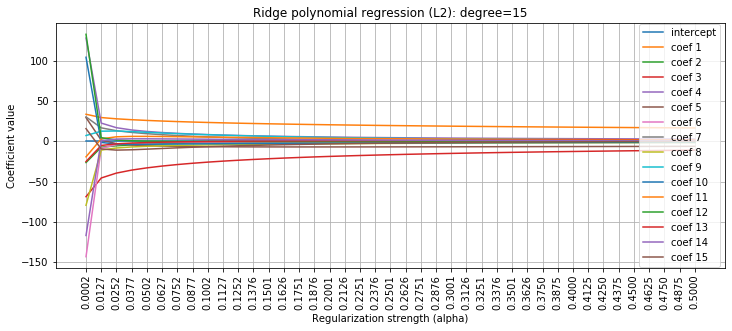

In [25]:
ALPHAS = np.linspace(0.0002, 0.5, 1 + 40)
coef_0, coef_1, coef_2, coef_3, coef_4, coef_5, coef_6, coef_7, coef_8, coef_9, coef_10, coef_11, coef_12, coef_13, coef_14, coef_15 = [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []
for alpha in ALPHAS:    
    results = make_model(degree=15, penalty='L2', alpha = alpha).fit(X_train, y_train)['reg'].coef_
    coef_0.append(results[0])
    coef_1.append(results[1])
    coef_2.append(results[2])
    coef_3.append(results[3])
    coef_4.append(results[4])
    coef_5.append(results[5])
    coef_6.append(results[6])
    coef_7.append(results[7])
    coef_8.append(results[8])
    coef_9.append(results[9])
    coef_10.append(results[10])
    coef_11.append(results[11])
    coef_12.append(results[12])
    coef_13.append(results[13])
    coef_14.append(results[14])
    coef_15.append(results[15])    
    
    
plot_coef_graph(ALPHAS, coef_0, coef_1, coef_2, coef_3, coef_4, coef_5, coef_6, coef_7, coef_8, coef_9, coef_10, coef_11, coef_12, coef_13, coef_14, coef_15,
                   xlabel='Regularization strength (alpha)', ylabel='Coefficient value',
                   title='Ridge polynomial regression (L2): degree=15')


#### Summary

Indeed, L1 is more likely to produce zero coefficients. As you can see on two graphs above, with the L1 penalization many coefficients are quickly becoming zeros, and only 2-3 core coefficient remain. This type of regression is handy to use for feature selection. It is good when there are only a few features with a medium/large effect.

In the same time, when we look at the L2 penalty plot, we can observe that all coefficient values become extremely small, they  almost approach the axis, but nevertheless they are still not zeros. Ridge regression tend to save all coefficients by giving them some - even miserable - weights. This type of regression is good when we have many small/medium size effects.

### Excercise 3 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Why is scaling important? What are the underlying reasons?

In exercises above we can see what Ridge/Lasso regressions are doing. They are regularizing the linear regression by imposing penalties on the size of the W coefficients. So the effect of increasing alpha is to shrink the W coefficients toward zero and toward each other. But if the input variables, the features, have very different scales, then when this shrinkage happens of the coefficients, input variables with different scales will have different contributions to L1/L2 penalties, because these penalties are the absolute sum/the sum of squares of all the coefficients. 

So transforming the input features so they are all on the same scale, means the penalty is applied more fairly to all features without unduly weighting some more than others, just because of the difference in scales.

The feauture scaling is important for many ML methods: all features are in the same scale ---> **faster convergence in learning** + **more uniform, 'fair' influence of all weights**.

Let's have a simple example and visualization how does the (`StandardScaler`) work. 
Suppose we have some stuff that can be measured by 2 features: height and width.

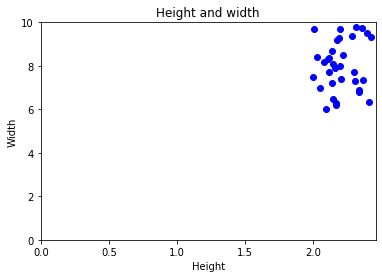

In [26]:
df = pd.DataFrame({'Height': [2.1, 2.05, 2.15, 2.0, 2.3, 2.2, 2.15, 2.17, 2.01, 2.4, 2.32, 2.34, 2.22, 2.11, 2.19, 2.14, 2.31, 2.21, 2.29, 2.03, 2.08, 2.18, 2.17, 2.34, 2.16, 2.36, 2.41, 2.37, 2.115, 2.43, 2.122, 2.143, 2.199], 
                   'Width': [6, 7, 6.5, 7.5, 7.7, 8, 8.1, 6.3, 9.7, 9.5, 9.8, 6.8, 8.5, 8.3, 9.3, 7.2, 7.3, 7.4, 9.4, 8.4, 8.2, 9.2, 6.2, 6.9, 7.9, 9.75, 6.35, 7.35, 8.35, 9.35, 7.7, 8.7, 9.7]})

f, ax = plt.subplots(1)
plt.scatter(df['Height'], df['Width'], c='blue')   
plt.title('Height and width')
ax.set_xlabel('Height')
ax.set_ylabel('Width')
ax.set_ylim(bottom=0)
ax.set_xlim(xmin=0)
plt.show()

As we can see, they have different scale: because width varies more, it is hard to notice changings in height.
So let's apply a StandardScaler() to this 2 features and plot the result.

In [27]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df.values)
scaled_features_df = pd.DataFrame(scaled_features, columns=df.columns)

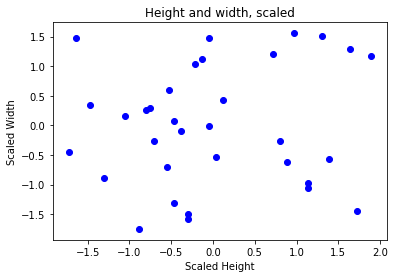

In [28]:
f, ax = plt.subplots(1)
plt.scatter(scaled_features_df['Height'], scaled_features_df['Width'], c='blue')  
ax.set_xlabel('Scaled Height')
ax.set_ylabel('Scaled Width')
plt.title('Height and width, scaled')
plt.show()

Now we can see a scaled picture. As have been said before, the feature scaling leads to more uniform, 'fair' influence of all weights.